# YOUR PROJECT TITLE

> **Note the following:** 
> 1. This is *not* meant to be an example of an actual **model analysis project**, just an example of how to structure such a project.
> 1. Remember the general advice on structuring and commenting your code
> 1. The `modelproject.py` file includes a function which could be used multiple times in this notebook.

Imports and set magics:

In [92]:
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# local modules
from OLGModel import OLGModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Model description

**Write out the model in equations here.** 

Make sure you explain well the purpose of the model and comment so that other students who may not have seen it before can follow.  

**Time:** Discrete and indexed by $t\in\{0,1,\dots\}$.

**Demographics:** Population is constant. A life consists of
two periods, *young* and *old*.

**Households:** As young a household supplies labor exogenously, $L_{t}=1$, and earns a after tax wage $(1-\tau_w)w_{t}$. Consumption as young and old
are denoted by $C_{1t}$ and $C_{2t+1}$. The after-tax return on saving is $(1-\tau_{r})r_{t+1}$. Utility is
    
$$
\begin{aligned}
U & =\max_{s_{t}\in[0,1]}\frac{C_{1t}^{1-\sigma}}{1-\sigma}+\beta\frac{C_{2t+1}^{1-\sigma}}{1-\sigma},\,\,\,\beta > -1, \sigma > 0\\
 & \text{s.t.}\\
 & S_{t}=s_{t}(1-\tau_{w})w_{t}\\
 & C_{1t}=(1-s_{t})(1-\tau_{w})w_{t}\\
 & C_{2t+1}=(1+(1-\tau_{r})r_{t+1})S_{t}
\end{aligned}
$$
    
The problem is formulated in terms of the saving rate $s_t\in[0,1]$.

Fully Funded (FF):
Government raises contributions from the young, invests these and pays them out with interes as benefits in the next period, giving the following budget constraints
$$c_{1t}+s_t+d_t = w_t(1-\tau)$$
$$c_{2t+1} = (1+r_{t+1})(s_t+\tau w_t)$$

Pay As You Go (PAYG):
Goverment raises contributions from current young, and pays them out as benefits to current old, giving the following budget constraints:
$$c_{1t}+s_t=w_t(1-\tau)$$
$$c_{2t+1}=(1+r_{t+1})s_t+(1+n)\tau w_{t+1}$$

**Firms:** Firms rent capital $K_{t-1}$ at the rental rate $r_{t}^{K}$,
and hires labor $E_{t}$ at the wage rate $w_{t}$. Firms have access
to the production function
    
$$
\begin{aligned}
Y_{t}=F(K_{t-1},E_{t})=(\alpha K_{t-1}^{-\theta}+(1-\alpha)E_{t}^{-\theta})^{\frac{1}{-\theta}},\,\,\,\theta>-1,\alpha\in(0,1)
\end{aligned}
$$
    
Profits are
    
$$
\begin{aligned}
\Pi_{t}=Y_{t}-w_{t}E_{t}-r_{t}^{K}K_{t-1}
\end{aligned}
$$

**Government:** Choose public consumption, $G_{t}$, and tax rates $\tau_w \in [0,1]$ and $\tau_r \in [0,1]$. Total tax revenue is
    
$$
\begin{aligned}
T_{t} &=\tau_r r_{t} (K_{t-1}+B_{t-1})+\tau_w w_{t}   
\end{aligned}
$$
    
Government debt accumulates according to
    
$$
\begin{aligned}
B_{t} &=(1+r^b_{t})B_{t-1}-T_{t}+G_{t} 
\end{aligned}
$$
       
A *balanced budget* implies $G_{t}=T_{t}-r_{t}B_{t-1}$.

**Capital:** Depreciates with a rate of $\delta \in [0,1]$.

**Equilibrium:**

1. Households maximize utility
2. Firms maximize profits
3. No-arbitrage between bonds and capital

    $$
    r_{t}=r_{t}^{K}-\delta=r_{t}^{b}
    $$

4. Labor market clears: $E_{t}=L_{t}=1$
5. Goods market clears: $Y_{t}=C_{1t}+C_{2t}+G_{t}+I_{t}$
6. Asset market clears: $S_{t}=K_{t}+B_{t}$
7. Capital follows its law of motion: $K_{t}=(1-\delta)K_{t-1}+I_{t}$

**Implication of profit maximization:** From FOCs

$$
\begin{aligned}
r_{t}^{k} & =F_{K}(K_{t-1},E_{t})=\alpha K_{t-1}^{-\theta-1}Y_{t}^{1+\theta}\\
w_{t} & =F_{E}(K_{t-1},E_{t})=(1-\alpha)E_{t}^{-\theta-1}Y_{t}^{1+\theta}
\end{aligned}
$$

**Implication of utility maximization:** From FOC

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta (1+(1-\tau_r)r_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

**Simulation algorithm:** At the beginning of period $t$, the
economy can be summarized in the state variables $K_{t-1}$ and $B_{t-1}$.  *Before* $s_t$ is known, we can calculate:

$$
\begin{aligned}
Y_{t} & =F(K_{t-1},1)\\
r_{t}^{k} & =F_{K}(K_{t-1},1)\\
w_{t} & =F_{E}(K_{t-1},1)\\
r_{t} & =r^k_{t}-\delta\\
r_{t}^{b} & =r_{t}\\
\tilde{r}_{t} & =(1-\tau_{r})r_{t}\\
C_{2t} & =(1+\tilde{r}_{t})(K_{t-1}+B_{t-1})\\
T_{t} & =\tau_{r}r_{t}(K_{t-1}+B_{t-1})+\tau_{w}w_{t}\\
B_{t} & =(1+r^b_{t})B_{t-1}+T_{t}-G_{t}\\
\end{aligned}
$$

*After* $s_t$ is known we can calculate:

$$
\begin{aligned}
C_{1t} & = (1-s_{t})(1-\tau_{w})w_{t}\\
I_{t} & =Y_{t}-C_{1t}-C_{2t}-G_{t}\\
K_{t} & =(1-\delta)K_{t-1} + I_t
\end{aligned}
$$

**Solution algorithm:** Simulate forward choosing $s_{t}$ so
that we always have

$$
\begin{aligned}
C_{1t}^{-\sigma}=\beta(1+\tilde{r}_{t+1})C_{2t+1}^{-\sigma}
\end{aligned}
$$

## Analytical solution

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

## Numerical solution

Setup of model

In [93]:
model = OLGModelClass()
par = model.par # SimpeNamespace
sim = model.sim # SimpeNamespace

# a. production
par.production_function = 'cobb-douglas'
par.theta = 0.0

# b. households
par.sigma = 1.0

# c. government
par.tau_w = 0.0
par.tau_r = 0.0
sim.balanced_budget[:] = True # G changes to achieve this

# d. initial values
K_ss = ((1-par.alpha)/((1+1.0/par.beta)))**(1/(1-par.alpha))
par.K_lag_ini = K_ss

initializing the model:
calling .setup()
calling .allocate()


Run model with and without shock to amount of labor

simulation done in 0.02 secs
simulation done in 0.03 secs


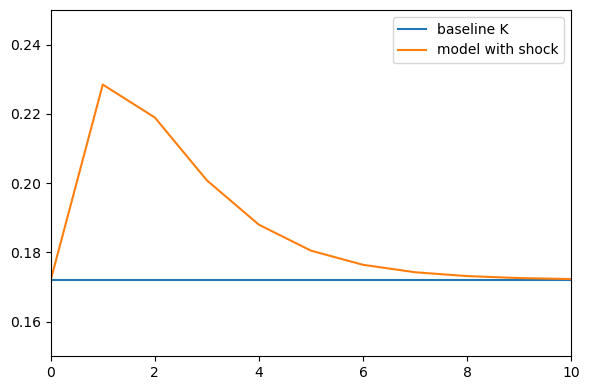

In [96]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

model.simulate(shock=False) # no shock
baseline = model.sim
ax.plot(baseline.K,label='baseline K')
model.simulate(shock=True)
shockmodel = model.sim

ax.plot(shockmodel.K,label='model with shock')
ax.legend(frameon=True)
plt.ylim([0.15, 0.25])
plt.xlim([0,10])
fig.tight_layout()




You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

Make detailed vizualizations of how your model changes with parameter values. 

Try to make an extension of the model. 

# Conclusion

Add concise conclusion. 